# This notebook offers some experiments on the paper:


"Globally and Locally Consistent Image Completion", SATOSHI IIZUKA, EDGAR SIMO-SERRA,
HIROSHI ISHIKAWA

The employed code comes from https://github.com/akmtn/pytorch-siggraph2017-inpainting

It requires a PyTorch version below 1.0.

In [1]:
%load_ext autoreload
%autoreload 2

from src.models import NetCompletion, NetContext
from src.masking import run_draw
from src.inpaint import inpainting, load_network, random_mask, load_mask, load_data, post_processing
from torch.nn.modules.loss import BCELoss, MSELoss
from torchsummary import summary
import cv2
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os
import urllib

model, datamean = load_network()
filename = "completionnet_places2.t7"
url = "http://hi.cs.waseda.ac.jp/~iizuka/data/completionnet_places2.t7"

if not os.path.isfile(filename):
    urllib.urlretrieve(url, filename)

# 1. Simple tests on an image
Code from https://stackoverflow.com/a/36382158/4986615

Press ESC to quit the windows.

In [29]:
img = cv2.imread("images/bridge.jpg")
run_draw(img, "mask.png")

Save image


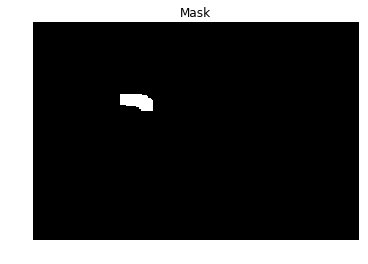

In [30]:
plt.figure()
mask = cv2.imread("mask.png")
plt.imshow(mask)
plt.axis('off')
plt.title("Mask")
plt.show()

In [60]:
M = load_mask("mask.png", output_shape=(600, 400))
I = load_data("images/bridge.jpg", output_shape=(600, 400))
out = inpainting(model, datamean, I, M, postproc=True)
vutils.save_image(out, 'out.png', normalize=True)

post-postprocessing...


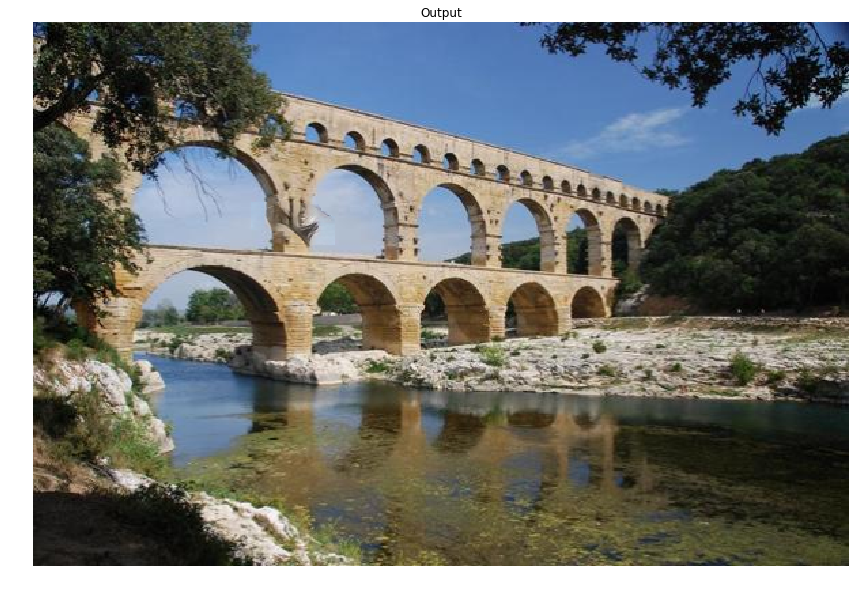

In [61]:
plt.figure(figsize=(20,10))
out_im = cv2.imread("out.png")[:,:,::-1] 
plt.imshow(out_im)
plt.axis('off')
plt.title("Output")
plt.show()

# 2. Computation of the loss function on a set of random masks
Here we want to draw a metric for the quality of the reconstruction.
We use a sum of a weighted MSE and a binary cross entropy as in the reference paper for training the generator.

In [98]:
wtl2 = 0.5
bce_loss = BCELoss()
mse_loss = MSELoss()
        
M = random_mask(output_shape=(600, 400))
I = load_data("images/bridge.jpg", output_shape=(600, 400))
out = inpainting(model, datamean, I, M, postproc=False)
out2 = out.float()      

error = wtl2*mse_loss(out2, I) + (1 - wtl2)*bce_loss(out2, I)
print("Normal:", error)

out_proc = post_processing(I, M, out)
out_proc2 = out_proc.float()      
error = wtl2*mse_loss(out_proc2, I) + (1 - wtl2)*bce_loss(out_proc2, I)
print("Post-processing:", error)

Random mask with 2 holes
Normal: tensor(0.2698)
Post-processing: tensor(0.2698)


# 3. Discriminator neural network

The local and global discriminators were not open-sourced. They are implemented in `models.py`

In [137]:
completion = NetCompletion()
summary(completion, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 508, 508]           4,864
       BatchNorm2d-2         [-1, 64, 508, 508]             128
              ReLU-3         [-1, 64, 508, 508]               0
            Conv2d-4        [-1, 128, 253, 253]          73,856
       BatchNorm2d-5        [-1, 128, 253, 253]             256
              ReLU-6        [-1, 128, 253, 253]               0
            Conv2d-7        [-1, 128, 251, 251]         147,584
       BatchNorm2d-8        [-1, 128, 251, 251]             256
              ReLU-9        [-1, 128, 251, 251]               0
           Conv2d-10        [-1, 256, 126, 126]          33,024
      BatchNorm2d-11        [-1, 256, 126, 126]             512
             ReLU-12        [-1, 256, 126, 126]               0
           Conv2d-13        [-1, 256, 126, 126]          65,792
      BatchNorm2d-14        [-1, 256, 1

In [37]:
from src.models import _NetContext
context = _NetContext()
summary(context, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 254, 254]           4,864
       BatchNorm2d-2         [-1, 64, 254, 254]             128
              ReLU-3         [-1, 64, 254, 254]               0
            Conv2d-4        [-1, 128, 125, 125]         204,928
       BatchNorm2d-5        [-1, 128, 125, 125]             256
              ReLU-6        [-1, 128, 125, 125]               0
            Conv2d-7          [-1, 256, 61, 61]         819,456
       BatchNorm2d-8          [-1, 256, 61, 61]             512
              ReLU-9          [-1, 256, 61, 61]               0
           Conv2d-10          [-1, 512, 29, 29]       3,277,312
      BatchNorm2d-11          [-1, 512, 29, 29]           1,024
             ReLU-12          [-1, 512, 29, 29]               0
           Conv2d-13          [-1, 512, 13, 13]       6,554,112
      BatchNorm2d-14          [-1, 512,